In [1]:
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score, auc, log_loss

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

**There are two phases to building a `tensorflow` model.**

1. Graph construction
2. Training/evaluation

## Building a Neural Network for Binary Classification

---

Now we'll build a neural net for _classification_.  
1. Load the data.
2. Data cleaning/munging, feature engineering (will not do today)
3. Make test/train splits. (Should we use cross validation?)
4. Standardize the data.
5. Build the computational graph for the neural network.
6. Train the network using gradient descent a.k.a. back propogation.
7. Evaluate performance and iterate.

In [3]:
df = pd.read_csv('../data/dataset5.gz', compression='gzip', header=0, sep=',', quotechar='"')

In [4]:
# Split the data
df_train, df_test = train_test_split(df, test_size = .3, random_state=42)

In [5]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = df_train[df_train['failure']==0]
df_minority = df_train[df_train['failure']==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df_train_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_train_upsampled['failure'].value_counts()


1    65524
0    65524
Name: failure, dtype: int64

In [6]:
# final x-values (features)
X_train=df_train_upsampled.drop(['failure', 'device'], axis=1)
X_test=df_test.drop(['failure', 'device'], axis=1)

In [7]:
# final y-values
y_train=df_train_upsampled['failure'].values
y1_test=df_test[['device','failure']] # Hold onto the device variable for later use, but remove it from the modeling data.
y_test=df_test['failure'].values

In [8]:
# confirm that lengths match
assert len(X_train)==len(y_train)
assert len(X_test)==len(y_test)

In [9]:
# Standardize variables

y_train = y_train*-1 + 1
y_test = y_test*-1 + 1

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [10]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, 
                   shape=(None,X_train.shape[1]),
                   name='X')
y = tf.placeholder(dtype=tf.float32,
                   shape=(None),
                   name='y')

hidden1 = tf.layers.dense(X, units=y_train.shape[1],
                          name='hidden1',
                          activation=tf.nn.relu)
y_hat = tf.layers.dense(hidden1, units=1,
                        name='y_hat',
                        activation=tf.nn.sigmoid)

loss = tf.losses.log_loss(y, y_hat)

optimizer = tf.train.AdamOptimizer(0.01)

training_op = optimizer.minimize(loss)

In [11]:
init = tf.global_variables_initializer()

test_err = []
train_err = []

with tf.Session() as sess:
    init.run()
    
    for epoch in range(501):
        sess.run(training_op,
                     feed_dict={X:X_train, y:y_train})
        
        train_loss = sess.run(loss, feed_dict={X:X_train, y:y_train})
        test_loss = sess.run(loss, feed_dict={X:X_test, y:y_test})
        test_err.append(test_loss)
        train_err.append(train_loss)
        if epoch % 10 == 0:
            print('epoch', epoch+1, train_loss, test_loss)
        
    pred = sess.run(y_hat, feed_dict={X:X_test})

epoch 1 0.7723722 0.5790646
epoch 11 0.64870584 0.55259377
epoch 21 0.58589697 0.4481223
epoch 31 0.5295682 0.33371615
epoch 41 0.49859485 0.28076744
epoch 51 0.47393262 0.27843407
epoch 61 0.4540556 0.29845908
epoch 71 0.43805817 0.3078956
epoch 81 0.42423776 0.30606622
epoch 91 0.41225004 0.30686414
epoch 101 0.40199688 0.3101119
epoch 111 0.39480203 0.30768788
epoch 121 0.3890934 0.31075463
epoch 131 0.3844852 0.31806016
epoch 141 0.3806682 0.32238638
epoch 151 0.37737992 0.3265144
epoch 161 0.37455243 0.33013824
epoch 171 0.3721157 0.33304211
epoch 181 0.37003767 0.3359358
epoch 191 0.36818898 0.33808863
epoch 201 0.36664864 0.34178457
epoch 211 0.36529875 0.34438977
epoch 221 0.36419806 0.3470402
epoch 231 0.3632592 0.34960893
epoch 241 0.36244896 0.35212013
epoch 251 0.36180484 0.35297158
epoch 261 0.36124837 0.35593185
epoch 271 0.36075282 0.35753357
epoch 281 0.3603149 0.3589636
epoch 291 0.35997105 0.36031023
epoch 301 0.35963514 0.361491
epoch 311 0.35936093 0.36308995
epoch 

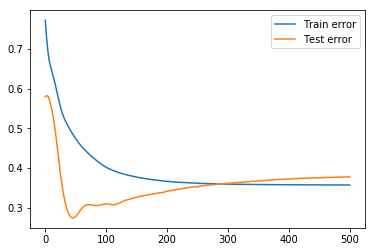

In [12]:
plt.plot(train_err, label='Train error')
plt.plot(test_err, label='Test error')
plt.legend()

In [13]:
pred_bin = (pred > 0.5).astype(int)

In [14]:
metrics.accuracy_score(y_test, pred_bin)

0.8564618832485504

In [15]:
metrics.confusion_matrix(y_test, pred_bin)

array([[   19,     6],
       [ 4029, 24057]])

In [16]:
pred[0], y_test[0]

(array([0.78992397], dtype=float32), array([1]))

In [17]:
# Calculate the roc-auc score
auc_rf=metrics.roc_auc_score(y_test, pred_bin)
acc_rf = metrics.accuracy_score(y_test, pred_bin)
f1_rf = metrics.f1_score(y_test, pred_bin)
# Display
print('F1 Score', "%.4f" % round(f1_rf,4))
print('Accuracy', "%.4f" % round(acc_rf,4))
print('AUC Score', "%.4f" % round(auc_rf,4))

F1 Score 0.9226
Accuracy 0.8565
AUC Score 0.8083


In [18]:
# Log loss. Can we beat random guessing? Lower is better.
guesses=np.full((len(y_test), ), .5)
print(log_loss(y_test, guesses))
print(log_loss(y_test, pred_bin)) 

0.6931471805599453
4.957631089290641
